In [ ]:
from google.colab import files
upload = files.upload()

Saving data.csv to data.csv


In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 
!pip install category_encoders==2.*
!pip install eli5

     / 38.3MB 845kB/s
     |████████████████████████████████| 81kB 4.0MB/s 
     |████████████████████████████████| 1.1MB 10.9MB/s 
     |████████████████████████████████| 3.2MB 20.5MB/s 
     |████████████████████████████████| 61kB 5.9MB/s 
     |████████████████████████████████| 81kB 6.9MB/s 
     |████████████████████████████████| 296kB 43.1MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.12.0-py2.py3-none-any.whl size=243829 sha256=262f2c14342dc82d033eb6b5ae472086ddb6d67a43f81ef0578244f48d5bf5cc
  Stored in directory: /tmp/pip-ephem-wheel-cache-sg5h5i2z/wheels/56/c2/dd/8d945b0443c35df7d5f62fa9e9ae105a2d8b286302b92e0109
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp37-none-any.whl size=27085 sha256=976015afc11445c438abf5c37d2a2106f613ee236109f5a165e0f24fdf3c9815
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Created wheel for phik: filename=phik-0.11.2-cp37-none-any.whl size=1107413 sha256=

In [ ]:
# importing our dataset which includes 175k songs pulled from Spotify's API from 1920 to 2020
# Setting our song ID as our index

import pandas as pd
df = pd.read_csv('data.csv',index_col='year', parse_dates=['year'])

In [ ]:
df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence
year,,,,,,,,,,,,,,,,,,
1920-01-01,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340
1920-01-01,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500
1920-01-01,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890
1920-01-01,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422
1920-01-01,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990


In [ ]:
# Defining our wrangle function
def wrangle(X):
  # Cleaning the artis column so there are all equal strings
  X['artists'] = X['artists'].str.replace('[','')
  X['artists'] = X['artists'].str.replace(']','')
  X['artists'] = X['artists'].str.replace('"','')
  X['artists'] = X['artists'].str.replace("'",'')
  X['artists'] = X['artists'].str.strip()
  # Dropping our release date as we already have the year and our dates are inconsistent
  X = X.drop('release_date', axis=1) 
  # Buckets of our popularity
  X.loc[(X['popularity'] >= 60),'popular'] = 'High'
  X.loc[(X['popularity'] < 10),'popular'] = 'Low'
  X.loc[((X['popularity'] >= 10) & (X['popularity'] < 60)),'popular'] = 'Medium'
  # Drop our IDs since they are useless now
  X = X.drop('id', axis = 1)
  # Drop our popularity feature to avoid target leaking
  X = X.drop('popularity', axis = 1)
  # Drop our song name since we are only predicting by song metrics
  X = X.drop('name', axis = 1)
  X = X.drop('artists', axis = 1)
  
  return X



In [ ]:
# Breaking out our train and test data
df1 = df.loc['2020']
df2 = df.loc['2021']

df1 = wrangle(df1)
test = wrangle(df2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [ ]:
df1.describe()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
count,4294.000000,4294.000000,4.294000e+03,4294.000000,4294.000000,4294.000000,4294.000000,4294.000000,4294.000000,4294.000000,4294.000000,4294.000000,4294.000000
mean,0.202303,0.605285,2.189775e+05,0.674247,0.175361,0.249008,5.307871,0.234415,-8.077563,0.592222,0.100629,124.058308,0.468030
std,0.285260,0.170268,1.201587e+05,0.228683,0.380320,0.368291,3.605357,0.210467,4.062681,0.491479,0.103757,25.525258,0.256424
min,0.000001,0.000000,8.042000e+03,0.004690,0.000000,0.000000,0.000000,0.011900,-35.708000,0.000000,0.000000,0.000000,0.000000
25%,0.003867,0.490000,1.624000e+05,0.530000,0.000000,0.000000,2.000000,0.097600,-9.391000,0.000000,0.039400,105.901500,0.255000
50%,0.053150,0.622000,2.065665e+05,0.707500,0.000000,0.000724,6.000000,0.140500,-7.151000,1.000000,0.057200,126.991000,0.460000
75%,0.285000,0.730000,2.513682e+05,0.862750,0.000000,0.613000,8.000000,0.314000,-5.566250,1.000000,0.112000,139.877250,0.674000
max,0.996000,0.980000,2.059336e+06,1.000000,1.000000,0.995000,11.000000,0.993000,0.977000,1.000000,0.954000,221.954000,0.997000


In [ ]:
df1['popular'].value_counts(normalize = True)

Low       0.495808
Medium    0.275966
High      0.228225
Name: popular, dtype: float64

In [ ]:
# Splitting our data
from sklearn.model_selection import train_test_split

train, val = train_test_split(df1, test_size = 0.2, random_state = 40)

In [ ]:
val.shape

(859, 14)

In [ ]:
# Defining our target and assigning features
target = 'popular'
features = train.columns.drop(target)

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]


In [ ]:
import category_encoders as ce 
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy = 'mean'),
    RandomForestClassifier(max_depth=12, n_jobs=-1,random_state=55)

)

pipeline.fit(X_train,y_train)
print('Val Accuracy:', pipeline.score(X_val,y_val))
print('Train accuracy:', pipeline.score(X_train, y_train))

Val Accuracy: 0.7869615832363213
Train accuracy: 0.9714701601164484


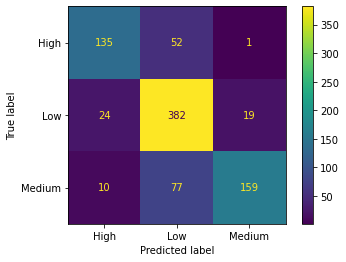

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(pipeline,X_val,y_val,values_format='.0f')


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestClassifier
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

permuter = PermutationImportance(
    model,
    scoring = 'accuracy',
    n_iter = 5
)
permuter.fit(X_val_transformed,y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [ ]:
feature_names = X_val.columns.to_list()
eli5.show_weights(
    permuter,
    top = None,
    feature_names = feature_names
)

Weight,Feature
0.0864 ± 0.0140,duration_ms
0.0820 ± 0.0135,explicit
0.0689 ± 0.0136,instrumentalness
0.0536 ± 0.0120,loudness
0.0438 ± 0.0084,energy
0.0400 ± 0.0120,tempo
0.0396 ± 0.0079,danceability
0.0363 ± 0.0131,valence
0.0326 ± 0.0067,liveness
0.0210 ± 0.0135,acousticness


In [ ]:
from joblib import dump
dump(pipeline,'pipeline.joblib',compress=True)

['pipeline.joblib']

In [ ]:
files.download('pipeline.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib
import sklearn
import category_encoders as ce
print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={ce.__version__}')

joblib==1.0.1
scikit-learn==0.22.2.post1
category_encoders==2.2.2


In [ ]:
feature_names

['acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'explicit',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'valence']

In [ ]:
def predict(acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,duration_ms,explicit,mode,key,loudness,
 tempo,):
 df = pd.DataFrame(
     columns['acousticness', 'danceability','duration_ms','energy','explicit','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','valence'],
     data = [[acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,
 mode,speechiness,tempo,valence]]
 )
 y_pred = pipeline.predict(df)[0]
 return f'{y_pred} potential of being a popular song in Spotify'

